# [ASTER の標高データを取得する](https://www.tellusxdp.com/ja/howtouse/access/20200221_000215.html)

## 標高データ (ASTER GDEM 2.0) を取得する

In [1]:
import os
import json

fpth_secret = os.path.join(os.environ['HOME'], 'jupyter/secret.json')
with open(fpth_secret) as f:
    secret = json.load(f)
TOKEN = secret['tellus']
HEADERS = {
    'Authorization': 'Bearer ' + TOKEN
}

<Response [200]>


/usr/local/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


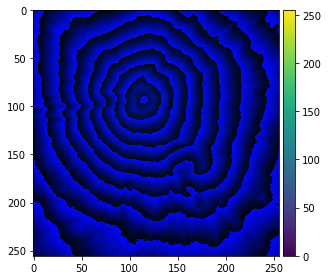

In [2]:
import requests
from skimage import io
from io import BytesIO
%matplotlib inline

def fetch_aster_gdem(tile):
    url = 'https://gisapi.tellusxdp.com'
    url += '/astergdem3/dsm/{z}/{x}/{y}.png'.format(**tile)
    
    r = requests.get(url, headers=HEADERS)
    
    print(r)
    return io.imread(BytesIO(r.content))

tile = {
    'x': 3626,
    'y': 1617,
    'z': 12
}
img = fetch_aster_gdem(tile)
io.imshow(img)

In [4]:
import numpy as np
def calc_height_img(img_rgb, u=100):
    r_ch, g_ch, b_ch = np.squeeze(np.split(img_rgb, 3, axis=-1))
    heights = np.zeros_like(r_ch, dtype=np.int64)
    
    heights = r_ch * 256 * 256 + g_ch * 256 + b_ch
    heights = np.where(heights > 2 ** 23, (heights - 2 ** 24) * u, heights)
    heights = np.where(heights < 2 ** 23, heights * u, heights)
    
    heights_err = np.where(heights == 2 ** 23)
    heights = np.where(heights == 2 ** 23, 0, heights)
    
    return heights, heights_err
    
z, err = calc_height_img(img, u=1)

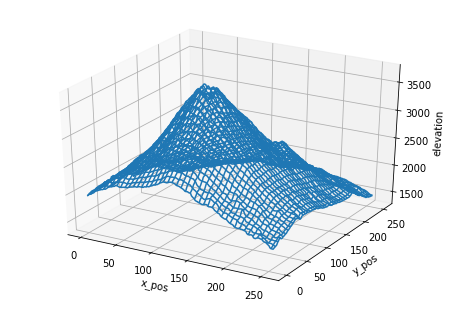

In [5]:
import math 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x, y = np.meshgrid(np.arange(256), np.arange(256))

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('x_pos')
ax.set_ylabel('y_pos')
ax.set_zlabel('elevation')
ax.plot_wireframe(x, y, z)
plt.show()

In [7]:
def num2deg(xtile, ytile, zoom):
    # https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg, lat_deg)
    
def calc_tile_bbox(tile):
    """
    タイル座標からバウンディングボックスを取得
    https://tools.ietf.org/html/rfc7946#section-5
    """
    right_top = num2deg(tile['x'] + 1, tile['y'], tile['z'])
    left_bottom = num2deg(tile['x'], tile['y'] + 1, tile['z'])
    return (left_bottom[0], left_bottom[1], right_top[0], right_top[1])

bbox = calc_tile_bbox(tile)
print(bbox)

(138.69140625, 35.31736632923787, 138.779296875, 35.389049966911664)


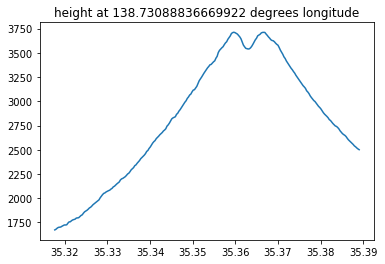

In [41]:
def calc_height_img_section(img_rgb, tile, index=0, direction=0, u=1):
    """
    画像の x, y 軸に沿って標高を計算
    
    緯度を固定して経度方向に標高を計算する場合 (direction = 1)
    (0, 0)                       (bbox[2], bbox[3])
    ------------------------------
    |
    |
    |##################### <- fixed_deg(lat)
    | |-> 左端 (deg = bbox[0]) から
    |     pix_per_deg づつ経度を加算
    |
    (bbox[0], bbox[1])
    
    経度を固定して緯度方向に標高を計算する場合 (direction = 0)
    (0, 0)                       (bbox[2], bbox[3])
    ------------------------------
    |     # <- fixed_deg(lon)
    |     #
    |     # || 上端 (deg = bbox[3]) から
    |     # \/ pix_per_deg づつ緯度を加算
    |     #
    |     #
    (bbox[0], bbox[1])
    """
    bbox = calc_tile_bbox(tile)
    width_lat = abs(bbox[2] - bbox[0])
    height_lon = abs(bbox[3] - bbox[1])
    
    if direction:
        # 緯度を固定して経度方向に標高を計算
        ext_section = img_rgb[index, :]
        fixed_deg = -1 * height_lon / img.shape[0] * index + bbox[3]
        deg = bbox[0]
        deg_per_pix = width_lat / ext_section.shape[0]
        title = f'height at {fixed_deg} degrees latitude'
    else:
        # 経度を固定して緯度方向に標高を計算
        ext_section = img_rgb[:, index]
        fixed_deg = width_lat / img.shape[1] * index + bbox[0]
        deg = bbox[3]
        # 経度は pix が増えると (赤道に近づくと) 減るので -1 をかける
        deg_per_pix = -1 * height_lon / ext_section.shape[0] 
        title = f'height at {fixed_deg} degrees longitude'
    
    degrees_slope = np.arange(ext_section.shape[0]) * deg_per_pix
    degrees_intercept = np.ones_like(degrees_slope) * deg
    degrees = degrees_slope + degrees_intercept
    
    heights, _ = calc_height_img(ext_section, u)
    
    return degrees, heights, title
    
degrees, heights, title = calc_height_img_section(img, tile, 115, 0)
fig, ax = plt.subplots()
plt.plot(degrees, heights)
plt.title(title)
plt.show()

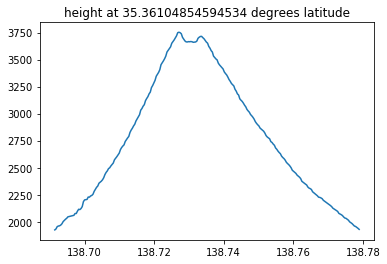

In [40]:
degrees, heights, title = calc_height_img_section(img, tile, 100, 1)
fig, ax = plt.subplots()
plt.plot(degrees, heights)
plt.title(title)
plt.show()